# **Question Overview**

In this HW you will design a backdoor detector for BadNets trained on the YouTube Face dataset using the pruning defense discussed in class. Your detector will take as input:
1. B​, a backdoored neural network classifier with ​N​ classes.
2. Dvalid​, a validation dataset of clean, labelled images.

What you must output is ​G ​a “repaired” BadNet. ​G​ has N+1 classes, and given unseen test input, it must:
1. Output the correct class if the test input is clean. The correct class will be in [1,N].
2. Output class N+1 if the input is backdoored.

You will design G using the pruning defense that we discussed in class. That is, you will prune the last pooling layer of BadNet B (the layer just before the FC layers) by removing one channel at a time from that layer. Channels should be removed in decreasing order of average activation values over the entire validation set. Every time you prune a channel, you will measure the new validation accuracy of the new pruned badnet. You will stop pruning once the validation accuracy drops atleast X% below the original accuracy. This will be your new network B'.
Now, your goodnet G works as follows. For each test input, you will run it through both B and B'. If the classification outputs are the same, i.e., class i, you will output class i. If they differ you will output N+1. Evaluat this defense on:
1. A BadNet, ​B1​ , (“sunglasses backdoor”) on YouTube Face for which we have already told you what the backdoor looks like. That is, we give you the validation data, and also test data with examples of clean and backdoored inputs.


In [1]:
# Mounting doodle drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
clean_valid_path= '/content/drive/MyDrive/backdoor-attacks/data/cl/valid.h5'
bad_valid_path = '/content/drive/MyDrive/backdoor-attacks/data/bd/bd_valid.h5'
bad_model_path ='/content/drive/MyDrive/backdoor-attacks/models/bd_net.h5'
eval_path = '/content/drive/MyDrive/backdoor-attacks/eval.py'
clean_test_path = '/content/drive/MyDrive/backdoor-attacks/data/cl/test.h5'
bad_test_path = '/content/drive/MyDrive/backdoor-attacks/data/bd/bd_test.h5'

In [4]:
import h5py
import numpy as np
import tensorflow as tf
import keras

def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x = np.array(data['data'])
    y = np.array(data['label'])
    x = x.transpose((0,2,3,1))
    return x, y

# Load the datasets
x_clean, y_clean = load_data(clean_valid_path)
x_bd, y_bd = load_data(bad_valid_path)


In [5]:
from keras.models import load_model

# Loading badnet madel
badnet = load_model(bad_model_path)


In [6]:
output_layer_shape = badnet.output_shape

N = output_layer_shape[-1]

print(f"Number of classes (N) is: {N}")

Number of classes (N) is: 1283


In [7]:
%cd /content/drive/MyDrive/backdoor-attacks
!python3 eval.py data/cl/test.h5 data/bd/bd_test.h5 models/bd_net.h5


/content/drive/MyDrive/backdoor-attacks
2023-12-05 04:41:16.391437: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 04:41:16.391477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 04:41:16.391501: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 04:41:17.595400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-05 04:41:28.375298: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original co

In [8]:
print(badnet.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

This segment of the code defines the prune_and_eval function, which is crucial for enhancing the robustness of neural network models against backdoor attacks. The function systematically prunes a given model by disabling channels in a convolutional layer. After each pruning step, it evaluates the model's performance on both clean and poisoned datasets. The function records the model's accuracy at each step, and if the accuracy drops below specified thresholds, it saves the pruned model. This approach helps in understanding the trade-off between model complexity and its vulnerability to attacks.

In [9]:
from tqdm import tqdm
import keras
import numpy as np

clean_accuracies = []
attack_success_rates = []

def prune_and_eval(model, clean_x, clean_y, bd_x, bd_y, clean_data_accuracy, pruning_thresholds):
    """
    Prunes a given neural network model by iteratively disabling channels in a convolutional layer
    and evaluates its performance on clean and backdoored data.

    Parameters:
    - model: The neural network model to be pruned.
    - clean_x: Clean input data.
    - clean_y: Labels for clean data.
    - bd_x: Backdoored input data.
    - bd_y: Labels for backdoored data.
    - clean_data_accuracy: The model's accuracy on clean data before pruning.
    - pruning_thresholds: Thresholds to determine significant accuracy drop.

    Returns:
    - saved_model_names: Names of models saved during pruning at different thresholds.
    """

    # Clone the original model to keep it unaffected during pruning
    cloned_model = keras.models.clone_model(model)
    cloned_model.set_weights(model.get_weights())

    # Getting the output of a specific intermediate layer
    intermediate_layer_output = cloned_model.get_layer('pool_3').output
    intermediate_model = keras.models.Model(inputs=cloned_model.input, outputs=intermediate_layer_output)

    # Generating intermediate predictions for clean data
    intermediate_predictions = intermediate_model.predict(clean_x)
    # Averaging over predictions to determine channel importance
    mean_intermediate_output = np.mean(intermediate_predictions, axis=(0, 1, 2))
    # Sorting indices by importance
    sorted_indices = np.argsort(mean_intermediate_output)

    # Extracting weights and biases from a specific convolutional layer
    conv_weights, conv_biases = cloned_model.layers[5].get_weights()

    # Tracking which models have been saved for each threshold
    models_saved = np.zeros(len(pruning_thresholds), dtype=bool)
    saved_model_names = []  # Names of the saved models

    # Iteratively prune each channel and evaluate the model
    for channel_idx in tqdm(sorted_indices):
        # Zero out the weights and biases of the current channel
        conv_weights[:, :, :, channel_idx] = 0
        conv_biases[channel_idx] = 0
        cloned_model.layers[5].set_weights([conv_weights, conv_biases])

        # Evaluate model on clean data
        predicted_labels_clean = np.argmax(cloned_model.predict(clean_x), axis=1)
        accuracy_clean = np.mean(np.equal(predicted_labels_clean, clean_y)) * 100

        # Evaluate model on backdoored data
        predicted_labels_attack = np.argmax(cloned_model.predict(bd_x), axis=1)
        success_rate_attack = np.mean(np.equal(predicted_labels_attack, bd_y)) * 100

        # Update accuracy lists for each pruning iteration
        clean_accuracies.append(accuracy_clean)
        attack_success_rates.append(success_rate_attack)

        # Print performance metrics for the current pruning iteration
        print(f"\nClean Data Accuracy: {accuracy_clean}%")
        print(f"Attack Success Rate: {success_rate_attack}%")
        print(f"Pruned Channel Index: {channel_idx}")

        # Check if the accuracy drop has reached any of the specified thresholds
        for idx, threshold in enumerate(pruning_thresholds):
            if clean_data_accuracy - accuracy_clean >= threshold * 100 and not models_saved[idx]:
                # Saving the model if the drop in accuracy crosses the threshold
                model_filename = f'model_X={threshold*100}.h5'
                print(f"Accuracy drop ≥ {threshold*100}%. Saving model as '{model_filename}'")
                cloned_model.save(model_filename)
                models_saved[idx] = True
                saved_model_names.append(model_filename)
                break  # Avoid saving at lower thresholds once a higher threshold is met

        # Clear the session to free up memory and resources
        keras.backend.clear_session()

    return saved_model_names

In [10]:
def evaluate_model(model, x_test, y_test):
    prediction = model.predict(x_test)
    # Calculate the accuracy
    # np.argmax(prediction, axis=1) converts predicted probabilities to class labels
    # The accuracy is computed as the mean of correct predictions
    accuracy = np.mean(np.argmax(prediction, axis=1) == y_test)
    return accuracy


In [11]:
#Calculating accuracy on badnet
clean_data_accuracy = evaluate_model(badnet, x_clean, y_clean)
print('Accuracy:{}'.format(clean_data_accuracy))

361/361 [==============================] - 2s 2ms/step
Accuracy:0.9864899974019226


In [12]:
threshold = [0.02, 0.04, 0.10]  # 2%, 4%, and 10%
pruned_models = prune_and_eval(badnet, x_clean, y_clean, x_bd, y_bd, clean_data_accuracy * 100, threshold)

361/361 [==============================] - 1s 2ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 0


  2%|▏         | 1/60 [00:03<03:55,  3.99s/it]

361/361 [==============================] - 1s 2ms/step


  3%|▎         | 2/60 [00:07<03:49,  3.95s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 26
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 27


  5%|▌         | 3/60 [00:11<03:45,  3.95s/it]

361/361 [==============================] - 1s 2ms/step


  7%|▋         | 4/60 [00:15<03:40,  3.94s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 30
361/361 [==============================] - 1s 2ms/step


  8%|▊         | 5/60 [00:19<03:37,  3.95s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 31
361/361 [==============================] - 1s 2ms/step


 10%|█         | 6/60 [00:23<03:32,  3.93s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 33
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 34


 12%|█▏        | 7/60 [00:27<03:29,  3.95s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 36


 13%|█▎        | 8/60 [00:31<03:26,  3.98s/it]

361/361 [==============================] - 1s 2ms/step


 15%|█▌        | 9/60 [00:35<03:22,  3.97s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 37
361/361 [==============================] - 1s 2ms/step


 17%|█▋        | 10/60 [00:39<03:17,  3.96s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 38
361/361 [==============================] - 1s 2ms/step


 18%|█▊        | 11/60 [00:43<03:14,  3.97s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 25
361/361 [==============================] - 1s 2ms/step


 20%|██        | 12/60 [00:47<03:09,  3.95s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 39
361/361 [==============================] - 1s 2ms/step


 22%|██▏       | 13/60 [00:51<03:05,  3.94s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 41
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 44


 23%|██▎       | 14/60 [00:55<03:03,  3.98s/it]

361/361 [==============================] - 1s 2ms/step


 25%|██▌       | 15/60 [00:59<02:58,  3.97s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 45
361/361 [==============================] - 1s 2ms/step


 27%|██▋       | 16/60 [01:03<02:54,  3.96s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 47
361/361 [==============================] - 1s 2ms/step


 28%|██▊       | 17/60 [01:07<02:51,  3.98s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 48
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 49


 30%|███       | 18/60 [01:11<02:46,  3.97s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 50


 32%|███▏      | 19/60 [01:15<02:42,  3.97s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 53


 33%|███▎      | 20/60 [01:19<02:39,  3.98s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 55


 35%|███▌      | 21/60 [01:23<02:35,  3.98s/it]

361/361 [==============================] - 1s 2ms/step


 37%|███▋      | 22/60 [01:27<02:30,  3.96s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 40
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 24


 38%|███▊      | 23/60 [01:31<02:26,  3.96s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 59


 40%|████      | 24/60 [01:35<02:23,  3.98s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 9


 42%|████▏     | 25/60 [01:39<02:19,  3.98s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 2


 43%|████▎     | 26/60 [01:43<02:15,  3.99s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 12


 45%|████▌     | 27/60 [01:47<02:11,  3.98s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 13


 47%|████▋     | 28/60 [01:51<02:07,  3.98s/it]

361/361 [==============================] - 1s 2ms/step


 48%|████▊     | 29/60 [01:55<02:03,  3.99s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 17
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 14


 50%|█████     | 30/60 [01:59<01:59,  3.98s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 15


 52%|█████▏    | 31/60 [02:03<01:55,  3.99s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 23


 53%|█████▎    | 32/60 [02:07<01:52,  4.02s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 6


 55%|█████▌    | 33/60 [02:11<01:48,  4.00s/it]

361/361 [==============================] - 1s 2ms/step


 57%|█████▋    | 34/60 [02:15<01:44,  4.02s/it]


Clean Data Accuracy: 98.64033948211657%
Attack Success Rate: 100.0%
Pruned Channel Index: 51
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.64033948211657%
Attack Success Rate: 100.0%
Pruned Channel Index: 32


 58%|█████▊    | 35/60 [02:19<01:40,  4.04s/it]

361/361 [==============================] - 1s 2ms/step


 60%|██████    | 36/60 [02:23<01:36,  4.01s/it]


Clean Data Accuracy: 98.63167922404088%
Attack Success Rate: 100.0%
Pruned Channel Index: 22
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.65765999826795%
Attack Success Rate: 100.0%
Pruned Channel Index: 21


 62%|██████▏   | 37/60 [02:27<01:31,  3.99s/it]

361/361 [==============================] - 1s 2ms/step


 63%|██████▎   | 38/60 [02:31<01:28,  4.00s/it]


Clean Data Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 20
361/361 [==============================] - 1s 2ms/step


 65%|██████▌   | 39/60 [02:35<01:23,  3.98s/it]


Clean Data Accuracy: 98.6056984498138%
Attack Success Rate: 100.0%
Pruned Channel Index: 19
361/361 [==============================] - 1s 2ms/step


 67%|██████▋   | 40/60 [02:39<01:19,  3.95s/it]


Clean Data Accuracy: 98.57105741751104%
Attack Success Rate: 100.0%
Pruned Channel Index: 43
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 98.53641638520828%
Attack Success Rate: 100.0%
Pruned Channel Index: 58


 68%|██████▊   | 41/60 [02:43<01:16,  4.05s/it]

361/361 [==============================] - 1s 2ms/step


 70%|███████   | 42/60 [02:47<01:12,  4.01s/it]


Clean Data Accuracy: 98.19000606218066%
Attack Success Rate: 100.0%
Pruned Channel Index: 3
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 97.65307006148784%
Attack Success Rate: 100.0%
Pruned Channel Index: 42


 72%|███████▏  | 43/60 [02:51<01:07,  3.98s/it]

361/361 [==============================] - 1s 2ms/step


 73%|███████▎  | 44/60 [02:55<01:04,  4.04s/it]


Clean Data Accuracy: 97.50584567420108%
Attack Success Rate: 100.0%
Pruned Channel Index: 1
361/361 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Clean Data Accuracy: 95.75647354291158%
Attack Success Rate: 100.0%
Pruned Channel Index: 29
Accuracy drop ≥ 2.0%. Saving model as 'model_X=2.0.h5'


 75%|███████▌  | 45/60 [02:59<01:02,  4.16s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 95.20221702606739%
Attack Success Rate: 99.9913397419243%
Pruned Channel Index: 16


 77%|███████▋  | 46/60 [03:03<00:57,  4.11s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 94.7172425738287%
Attack Success Rate: 99.9913397419243%
Pruned Channel Index: 56


 78%|███████▊  | 47/60 [03:07<00:53,  4.11s/it]

361/361 [==============================] - 1s 2ms/step



Clean Data Accuracy: 92.09318437689443%
Attack Success Rate: 99.9913397419243%
Pruned Channel Index: 46
Accuracy drop ≥ 4.0%. Saving model as 'model_X=4.0.h5'


 80%|████████  | 48/60 [03:12<00:50,  4.24s/it]

361/361 [==============================] - 1s 2ms/step


 82%|████████▏ | 49/60 [03:16<00:45,  4.14s/it]


Clean Data Accuracy: 91.49562656967177%
Attack Success Rate: 99.9913397419243%
Pruned Channel Index: 5
361/361 [==============================] - 1s 2ms/step


 83%|████████▎ | 50/60 [03:20<00:41,  4.11s/it]


Clean Data Accuracy: 91.01931237550879%
Attack Success Rate: 99.98267948384861%
Pruned Channel Index: 8
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 89.17467740538669%
Attack Success Rate: 80.73958603966398%
Pruned Channel Index: 11


 85%|████████▌ | 51/60 [03:24<00:36,  4.08s/it]

361/361 [==============================] - 1s 2ms/step



Clean Data Accuracy: 84.43751623798389%
Attack Success Rate: 77.015675067117%
Pruned Channel Index: 54
Accuracy drop ≥ 10.0%. Saving model as 'model_X=10.0.h5'


 87%|████████▋ | 52/60 [03:28<00:33,  4.16s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 76.48739932449988%
Attack Success Rate: 35.71490430414826%
Pruned Channel Index: 10


 88%|████████▊ | 53/60 [03:32<00:28,  4.13s/it]

361/361 [==============================] - 1s 2ms/step


 90%|█████████ | 54/60 [03:36<00:24,  4.11s/it]


Clean Data Accuracy: 54.8627349095003%
Attack Success Rate: 6.954187234779596%
Pruned Channel Index: 28
361/361 [==============================] - 1s 2ms/step


 92%|█████████▏| 55/60 [03:40<00:20,  4.07s/it]


Clean Data Accuracy: 27.08928726076037%
Attack Success Rate: 0.4243526457088421%
Pruned Channel Index: 35
361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 13.87373343725643%
Attack Success Rate: 0.0%
Pruned Channel Index: 18


 93%|█████████▎| 56/60 [03:44<00:16,  4.06s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 7.101411622066338%
Attack Success Rate: 0.0%
Pruned Channel Index: 4


 95%|█████████▌| 57/60 [03:48<00:12,  4.05s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 1.5501861955486274%
Attack Success Rate: 0.0%
Pruned Channel Index: 7


 97%|█████████▋| 58/60 [03:52<00:08,  4.04s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 0.7188014202823244%
Attack Success Rate: 0.0%
Pruned Channel Index: 52


 98%|█████████▊| 59/60 [03:56<00:04,  4.05s/it]

361/361 [==============================] - 1s 2ms/step

Clean Data Accuracy: 0.0779423226812159%
Attack Success Rate: 0.0%
Pruned Channel Index: 57


100%|██████████| 60/60 [04:00<00:00,  4.01s/it]


In [13]:
print(pruned_models)

['model_X=2.0.h5', 'model_X=4.0.h5', 'model_X=10.0.h5']


The construct_goodnet function is a novel approach to mitigating backdoor attacks in neural networks. This function creates a new model, termed 'GoodNet', which integrates predictions from the original compromised model (BadNet) and its pruned version. GoodNet compares predictions from both models and, in cases of disagreement, defaults to predicting an additional class representing the backdoor. This strategy is aimed at neutralizing the backdoor triggers while maintaining the model's performance on clean data.

In [14]:
def construct_goodnet(badnet, pruned_badnet, n_classes):
    def goodnet_predict(input_data):
        pred_B = np.argmax(badnet.predict(input_data), axis=1)
        pred_B_prime = np.argmax(pruned_badnet.predict(input_data), axis=1)
        # If both models agree on the prediction, use it; otherwise, predict the additional class (backdoor)
        output_pred = np.where(pred_B == pred_B_prime, pred_B, n_classes)
        return output_pred

    return goodnet_predict

In [15]:
# For getting back saved models and evaluating
pruned_models = ['model_X=2.0.h5', 'model_X=4.0.h5', 'model_X=10.0.h5']

In [16]:
# from tensorflow.keras.models import load_model

# loaded_pruned_models = [load_model(filename) for filename in pruned_models]
# # Construct a list of GoodNet models by combining BadNet with each pruned model
# # N represents the number of classes in the dataset
# goodnets = [construct_goodnet(badnet, loaded_pruned_model, N) for loaded_pruned_model in loaded_pruned_models]

from tensorflow.keras.models import load_model

# Assuming badnet is already a loaded model object
# Load pruned models
loaded_pruned_models = [load_model(filename) for filename in pruned_models]

# Construct GoodNets with loaded models
goodnets = [construct_goodnet(badnet, loaded_pruned_model, N) for loaded_pruned_model in loaded_pruned_models]


In this part of the code, the eval_goodnet function is introduced to evaluate the effectiveness of GoodNet models. This function tests the GoodNet on both clean and poisoned datasets. It calculates the accuracy of the GoodNet on clean data, reflecting its ability to perform standard classification tasks. Additionally, it computes the detection rate of the poisoned data, indicating the effectiveness of GoodNet in identifying and countering backdoor attacks. The results from this evaluation provide insights into the balance achieved between maintaining classification accuracy and mitigating backdoor threats.

In [17]:
def eval_goodnet(goodnet, x_clean_test, y_clean_test, x_poisoned_test, y_poisoned_test, n_classes):

    clean_pred = goodnet(x_clean_test)
    poisoned_pred = goodnet(x_poisoned_test)
    # Calculating accuracy on clean test data
    clean_accuracy = np.mean(clean_pred == y_clean_test)
    # Calculating detection rate of poisoned data (assuming correct labels are known)\
    detection_rate = np.mean(poisoned_pred == y_poisoned_test)
    return clean_accuracy, detection_rate

In [18]:
x_clean_test, y_clean_test = load_data(clean_test_path)
x_poisoned_test, y_poisoned_test = load_data(bad_test_path)

In [19]:
accuracies = []
detection_rates = []

# Evaluating each GoodNet model in the list 'goodnets'
for i, goodnet in enumerate(goodnets):
    # Evaluate GoodNet on both clean and poisoned test data
    accuracy, detection_rate = eval_goodnet(
        goodnet, x_clean_test, y_clean_test, x_poisoned_test, y_poisoned_test, N+1
    )
    accuracies.append(accuracy * 100)  # Convert to percentage
    detection_rates.append(detection_rate * 100)
    print(f"GoodNet {i}: Accuracy = {accuracy*100:.2f}%, Detection Rate = {detection_rate*100:.2f}%")

401/401 [==============================] - 1s 2ms/step
GoodNet 0: Accuracy = 95.74%, Detection Rate = 100.00%
401/401 [==============================] - 1s 2ms/step
GoodNet 1: Accuracy = 92.13%, Detection Rate = 99.98%
401/401 [==============================] - 1s 2ms/step
GoodNet 2: Accuracy = 84.33%, Detection Rate = 77.21%


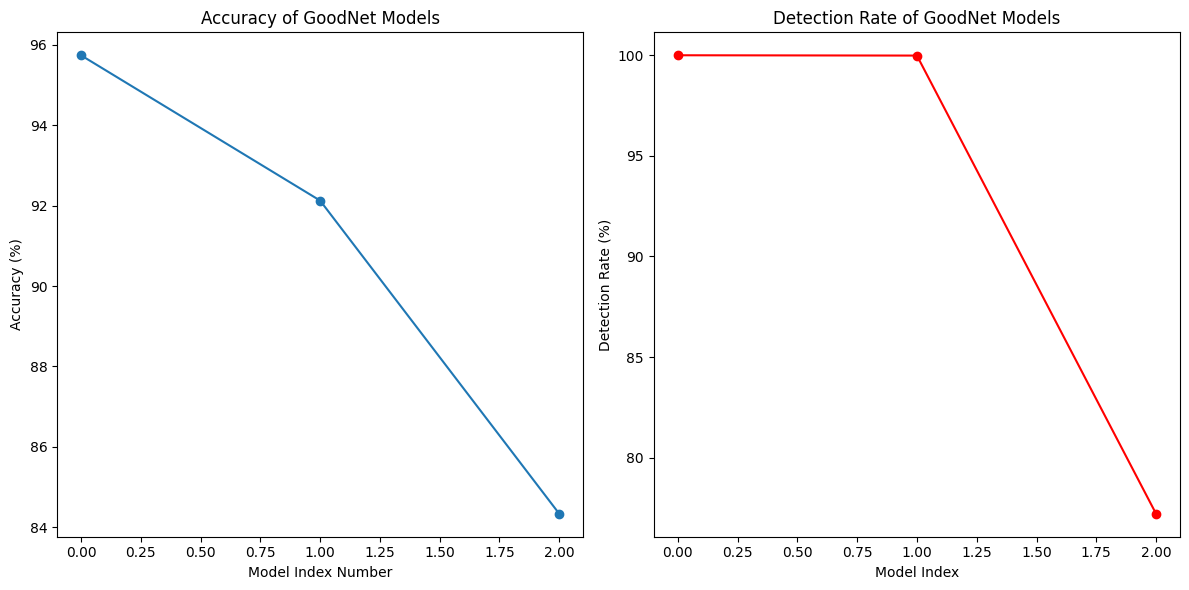

In [20]:
import matplotlib.pyplot as plt
# Set up the figure and axes for two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting accuracies
ax1.plot(accuracies, marker='o')
ax1.set_title('Accuracy of GoodNet Models')
ax1.set_xlabel('Model Index Number')
ax1.set_ylabel('Accuracy (%)')

# Plotting detection rates
ax2.plot(detection_rates, marker='o', color='red')
ax2.set_title('Detection Rate of GoodNet Models')
ax2.set_xlabel('Model Index')
ax2.set_ylabel('Detection Rate (%)')

# Show the plot
plt.tight_layout()
plt.show()